# CORE MICROBIOME STUDIES

In [1]:
import pandas as pd
import scipy.stats as stats
import numpy as np
import seaborn as sns
import scikit_posthocs as sp
import matplotlib.pyplot as plt

import os

In [2]:
script_dir = os.getcwd()
os.chdir("../results/core_res")
res_dir = os.getcwd()
os.chdir("../../data/clean_data")
data_dir = os.getcwd()

In [4]:
# here should go the part of the code which I coded yesterday in which each core is found and printed as a result. 
# As a temporary make-do, I'm copy-pasting the results straight in 


all_data = pd.read_csv("ab_data_all_fixed.csv", index_col = 0)
# Fix names for consistency sake
#all_data.loc[all_data["type_g"] == "control", "type_g"] = "Surrounding \n soil"
#all_data.loc[all_data["type_g"] == "plastic", "type_g"] = "Greenhouse \n plastic waste"
#all_data.loc[all_data["place"] == "inv", "place"] = "S1"
#all_data.loc[all_data["place"] == "sapo", "place"] = "S2"
#all_data.loc[all_data["place"] == "alm4", "place"] = "S3"
all_data.loc[all_data["antib"] == "Phenicol", "antib"] = "Amphenicol"

# Fix a bunch of badly assigned resistances 
all_data.loc[all_data["antib"] == "Other", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA1", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA12", "antib"] = "Trimethoprim"
all_data.loc[all_data["Assay"] == "dfrA1", "or_seq"] = "arg"
all_data.loc[all_data["Assay"] == "dfrA12", "or_seq"] = "arg"


all_data.rename(columns = {"antib":"Resistance"}, inplace = True)
all_data.head()

,Assay,Resistance,sample,Ct,place,type_f,type_g,or_seq,rel_n,rel_ab,log_n,rel_16
0,aacC2,Aminoglycoside,25.0,23.78,ardley,PUR,plastic,arg,9.246982,0.000222,-3.654,41686.938347
1,aacA/aphD,Aminoglycoside,25.0,26.05,ardley,PUR,plastic,arg,1.927525,0.000046,-4.335,41686.938347
2,aac(6')-II,Aminoglycoside,25.0,18.80,ardley,PUR,plastic,arg,288.403150,0.006918,-2.160,41686.938347
3,aphA3,Aminoglycoside,25.0,0.00,ardley,PUR,plastic,arg,NaN,NaN,NaN,41686.938347
4,sat4,Aminoglycoside,25.0,0.00,ardley,PUR,plastic,arg,NaN,NaN,NaN,41686.938347


In [43]:
PUR_core = all_data.loc[(all_data["type_f"] == "PUR") & (all_data["Ct"] > 0)][["Assay", "sample"]]
PUR_core = PUR_core["Assay"].value_counts() == 8
PUR_core_lst = list(PUR_core.loc[PUR_core == True].index)

EPS_core = all_data.loc[(all_data["type_f"] == "EPS") & (all_data["Ct"] > 0)][["Assay", "sample"]]
EPS_core = EPS_core["Assay"].value_counts() == 8
EPS_core_lst = list(EPS_core.loc[EPS_core == True].index)

water_core = all_data.loc[(all_data["type_f"] == "water") & (all_data["Ct"] > 0)][["Assay", "sample"]]
water_core = water_core["Assay"].value_counts() == 4
water_core_lst = list(water_core.loc[water_core == True].index)

soil_core = all_data.loc[(all_data["type_f"] == "soil") & (all_data["Ct"] > 0)][["Assay", "sample"]]
soil_core = soil_core["Assay"].value_counts() == 7
soil_core_lst = list(soil_core.loc[soil_core == True].index)

print(PUR_core_lst, EPS_core_lst, water_core_lst, soil_core_lst)

['erm(E)', 'aac3-Via', 'aph3-ib', 'erm(O)', 'intl3'] ['mdtg', 'intl3', 'aac3-Via', 'aph4ib'] ['aac3-Via', 'trb-C'] []


In [47]:
EPS_core = all_data.loc[all_data["Assay"].isin(EPS_core_lst)]
PUR_core = all_data.loc[all_data["Assay"].isin(PUR_core_lst)]
water_core = all_data.loc[all_data["Assay"].isin(water_core_lst)]

all_cores = all_data.loc[(all_data["Assay"].isin(EPS_core_lst)) | all_data["Assay"].isin(PUR_core_lst) | all_data["Assay"].isin(water_core_lst)]
#there's no soil core to compare against

### NCN comparisions
First, NCN comparisions to check whether plastic samples stay equal

In [50]:
os.chdir(res_dir)
all_grouped = all_cores.groupby(["sample", "or_seq", "place", "type_g"]) #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples = all_grouped["rel_ab"].sum() # y calcula la suma del nº de copias de todos los integrantes
summed_samples = summed_samples.reset_index() #aquí paso a df para facilitar el resto de pasos
summed_samples["n_log2"] = np.log2(summed_samples["rel_ab"] + 1)

summed_samples.tail()

,sample,or_seq,place,type_g,rel_ab,n_log2
49,25.0,mge,ardley,plastic,2.703958,1.889068
50,26.0,arg,ardley,plastic,3.977483,2.315416
51,26.0,mge,ardley,plastic,7.851848,3.145979
52,27.0,arg,ardley,plastic,4.509276,2.461863
53,27.0,mge,ardley,plastic,7.972525,3.165514


In [51]:
var_lst = [group["rel_ab"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["place", "type_g"])] #contains every group
nam_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["place", "type_g"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "arg"].groupby(["place", "type_g"])]
print("Log2: ", stats.levene(*var_lst_ln))
with open("core_arg_statistics.txt", "w") as file:
    print("Regular_values: ", stats.levene(*var_lst), file = file)
    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)

Regular values:  LeveneResult(statistic=3.054225617511905, pvalue=0.03167060033147562)
Log2:  LeveneResult(statistic=3.0610826164163805, pvalue=0.031407362463766346)


In [52]:
print(stats.kruskal(*var_lst))
post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

post_lolo.to_csv("all_core_arg_comparisions.csv")
post_lolo

KruskalResult(statistic=20.213834555827226, pvalue=0.001139355750557341)


,"(ardley, control)","(ardley, plastic)","(ion, control)","(ion, plastic)","(uru, control)","(uru, plastic)"
"(ardley, control)",1.000000,0.007145,0.023451,0.762160,0.012930,0.823057
"(ardley, plastic)",0.007145,1.000000,0.000058,0.008105,0.000002,0.000968
"(ion, control)",0.023451,0.000058,1.000000,0.009714,0.787379,0.020281
"(ion, plastic)",0.762160,0.008105,0.009714,1.000000,0.004405,0.558631
"(uru, control)",0.012930,0.000002,0.787379,0.004405,1.000000,0.007988
"(uru, plastic)",0.823057,0.000968,0.020281,0.558631,0.007988,1.000000


In [53]:
var_lst = [group["rel_ab"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "mge"].groupby(["place", "type_g"])] #contains every group
nam_lst = [name for name, group in summed_samples.loc[summed_samples["or_seq"] == "mge"].groupby(["place", "type_g"])] #contains the name of everygroup, SAME ORDER
print("Regular values: ", stats.levene(*var_lst))
var_lst_ln = [group["n_log2"] for name, group in summed_samples.loc[summed_samples["or_seq"] == "mge"].groupby(["place", "type_g"])]
print("Log2: ", stats.levene(*var_lst_ln))
with open("core_mge_statistics.txt", "w") as file:
    print("Regular_values: ", stats.levene(*var_lst), file = file)
    print("Regular_kruskal: ", stats.kruskal(*var_lst), file = file)
    print("Log2_values: ", stats.levene(*var_lst_ln), file = file)
    print("Log2_kruskal: ", stats.kruskal(*var_lst_ln), file = file)

Regular values:  LeveneResult(statistic=0.9688352550761065, pvalue=0.4591946490001557)
Log2:  LeveneResult(statistic=0.8444052328710787, pvalue=0.5336092399843574)


In [54]:
print(stats.kruskal(*var_lst))
post_lolo = sp.posthoc_conover(var_lst, p_adjust = "fdr_bh")

post_lolo.rename(columns = {original_num:new_name for (original_num, new_name) in zip(post_lolo.columns, nam_lst)},
                 index = {original_num:new_name for (original_num, new_name) in zip(post_lolo.index, nam_lst)},
                 inplace = True)

post_lolo.to_csv("all_core_mge_comparisions.csv")
post_lolo

KruskalResult(statistic=20.81377343113284, pvalue=0.0008783728245044587)


,"(ardley, control)","(ardley, plastic)","(ion, control)","(ion, plastic)","(uru, control)","(uru, plastic)"
"(ardley, control)",1.000000,0.000001,0.366235,0.002141,0.000283,0.007548
"(ardley, plastic)",0.000001,1.000000,0.000037,0.000901,0.002141,0.000037
"(ion, control)",0.366235,0.000037,1.000000,0.043548,0.007893,0.127788
"(ion, plastic)",0.002141,0.000901,0.043548,1.000000,0.404106,0.366235
"(uru, control)",0.000283,0.002141,0.007893,0.404106,1.000000,0.072287
"(uru, plastic)",0.007548,0.000037,0.127788,0.366235,0.072287,1.000000


In [57]:
summed_samples = all_cores.groupby(["sample", "or_seq", "place", "type_g"])["rel_ab"].sum().reset_index() #agrupa los datos según tipología. LO importante, también por nº de muestra
summed_samples["hacky"] = summed_samples["place"] + " " + summed_samples["type_g"]
summed_samples.sort_values(by = "hacky", inplace = True)
summed_samples["n_log2"] = np.log10(summed_samples["rel_ab"] +1 )
arg_general_sums = summed_samples.loc[summed_samples["or_seq"] == "arg"]
mge_general_sums = summed_samples.loc[summed_samples["or_seq"] == "mge"]

In [58]:
arg_general_sums

,sample,or_seq,place,type_g,rel_ab,hacky,n_log2
36,19.0,arg,ardley,control,1.302199,ardley control,0.362143
38,20.0,arg,ardley,control,1.820311,ardley control,0.450297
40,21.0,arg,ardley,control,0.000000,ardley control,0.000000
52,27.0,arg,ardley,plastic,4.509276,ardley plastic,0.741095
42,22.0,arg,ardley,plastic,4.727399,ardley plastic,0.757957
46,24.0,arg,ardley,plastic,3.589058,ardley plastic,0.661724
48,25.0,arg,ardley,plastic,6.270593,ardley plastic,0.861570
50,26.0,arg,ardley,plastic,3.977483,ardley plastic,0.697010
44,23.0,arg,ardley,plastic,4.205391,ardley plastic,0.716453
24,13.0,arg,ion,control,0.000566,ion control,0.000246


In [59]:
list(sns.color_palette(as_cmap = True))

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

/tmp/ipykernel_3478/4001144534.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cat = sns.catplot(data = arg_general_sums, kind="bar",


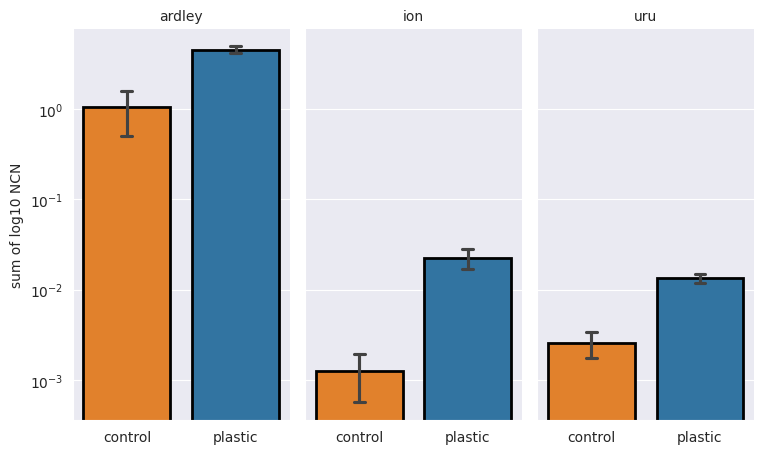

In [60]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = arg_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="place",
                      height=5, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black",# hue = "type_g",
                      hue_order = ["Greenhouse \n plastic waste", "Surrounding \n soil", ],
                      fill = True,  edgecolor = "black", linewidth = 2,
                      palette = ['#ff7f0e', "#1f77b4"]
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.set_xlabels("")
    cat.set_ylabels("sum of log10 NCN")
    plt.yscale("log")
    cat.set_titles("{col_name}")
plt.savefig("Site separated core-ARG log2 NCN.png", bbox_inches= "tight")

/tmp/ipykernel_3478/1246519034.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  cat = sns.catplot(data = mge_general_sums, kind="bar",


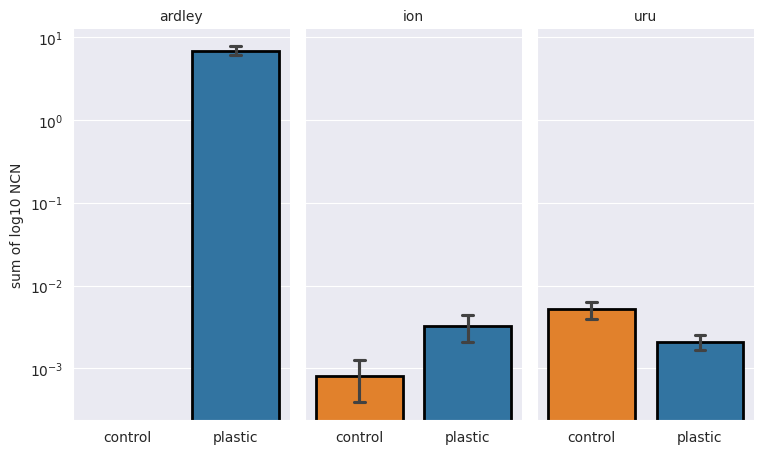

In [61]:
with sns.axes_style("darkgrid"):
    cat = sns.catplot(data = mge_general_sums, kind="bar",
                      x="type_g", y="rel_ab", col="place",
                      height=5, aspect=0.5,
                      errorbar = "se", capsize = 0.1, ecolor = "black",# hue = "type_g",
                      hue_order = ["Greenhouse \n plastic waste", "Surrounding \n soil", ],
                      fill = True,  edgecolor = "black", linewidth = 2,
                      palette = ['#ff7f0e', "#1f77b4"]
                    )
    cat.fig.subplots_adjust(top=0.9)
    cat.set_xlabels("")
    cat.set_ylabels("sum of log10 NCN")
    plt.yscale("log")
    cat.set_titles("{col_name}")
plt.savefig("Site separated core-MGE log2 NCN.png", bbox_inches= "tight")